In [1]:
# GENERAL
import os
import json
import os
import re
import sys
from copy import deepcopy
from collections import Counter
# SCIENTIFIC - DATA SCIENCE
import pandas as pd
import numpy as np
import scipy
import scipy as sci
from scipy import stats
# PLOT RELATED
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib.image as mpimg
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# THIS WORK SPECIFIC
from utils.humanlogbank import HumanLogBank
from utils.humanlogbank import Attentioner
from utils.humanlogbank import Downloader
from utils.humanlogbank import StandardValidator
from utils.humanlogbank import AnomalyAnalyzer
from utils.modelofcode import ModelOfCode
from utils.humanlogbank import CsvAmazonValidator
from utils.modelofcode import ModelOfCode
from utils.comparer import Comparer
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
# Configuration     
OUT_PlOT_FOLDER = 'paper_figures'  # where to save your output figures
STYLE_PATH_FSE = 'paper_figures/personalized_style.mplstyle'
STYLE_PATH_DEFAULT = 'default'
ALLAMANIS_MODEL_NAME = 'CNN'
TRANSFORMER_MODEL_NAME = 'Transformer'

In [5]:
ALLAMANIS_ATTENTION_FILE = '../data/precomputed_model_prediction/extreme_summarizer/machine_attention.json'
TRANSFORMER_ATTENTION_FILE_ = '../data/precomputed_model_prediction/transformer/machine_attention.json'
HUMAN_ATTENTION_FILE = '../data/processed_human_attention/attentions_processed_also_rejected_users.json'

USER_EVALUATION_PATH = '../data/user_info/users_evaluation.csv'
USER_PROVENANCE = '../data/user_info/users_provenance.csv'

# Load Attention Weights
Read the attention data from humans and the attention weights extracted by the neural models.

In [6]:
df_machine_allamanis = pd.read_json(ALLAMANIS_ATTENTION_FILE, orient='records')
df_machine_transformer = pd.read_json(TRANSFORMER_ATTENTION_FILE_, orient='records')
df_human = pd.read_json(HUMAN_ATTENTION_FILE, orient='records')

In [7]:
print('Initial Attention Records')
len(df_human)

Initial Attention Records


3122

# Data Cleaning: Filter out random guesser participants
As explained in the paper, we discard all the collected data from participants which obtained a result which could have been obtained also by a random guesse with a probability higher than 0.05.

In [8]:
df_users_evaluation = pd.read_csv(USER_EVALUATION_PATH)

In [9]:
CUTOFF_PROB = 0.05
accepted_users = list(df_users_evaluation[
    df_users_evaluation['prob_random_acceptance'] <= CUTOFF_PROB
]['randomcode'])

In [10]:
print('Number of Accepted Users:')
len(accepted_users)

Number of Accepted Users:


101

In [11]:
df_human = df_human[
    df_human['randomcode'].isin(accepted_users)
]
print('Retained Human Attention Records')
len(df_human)

Retained Human Attention Records


1700

In [12]:
df_accepted_users = df_users_evaluation[
    df_users_evaluation['prob_random_acceptance'] <= CUTOFF_PROB
]

# Correlation Study: Human vs Machine
Compare human attention against machine attention computing the correlation scores. Note that each model has two types of attention: regular and copy attention.

In [13]:
# ALLAMANIS
cmp_allamanis = Comparer(
    df_human=df_human, 
    df_machine=df_machine_allamanis)
cmp_allamanis.compute_correlations(
    human_attention_col='att_vector_w_click',
    machine_attention_cols=[
        'att_vector_avg',
        'copy_att_vector_avg'],
    ranking_measures=True,
    overlapping_measures=False,
    also_per_token_kind_restricted=False
)

cmp_allamanis.compute_model_performance()
df_comparative_study_allamanis = cmp_allamanis.get_compare_df(only_min_n_annotators=5)

INFO:attention-comparer:379 machine functions


['_id', 'att_tokens', 'att_vector_human', 'att_vector_w_click', 'body_string', 'cap_original_tokens', 'completejsexecution', 'error_on_random', 'error_on_tfidf', 'experimentset', 'file_name', 'fileindex', 'finalclickedtokens', 'formatted_lines', 'formattedcode', 'from_valid_user', 'function_name', 'function_name_tokens', 'functionnamebyuser', 'handmade_category', 'id', 'id_body_hash', 'id_same_identifier_list', 'is_amtruk_user', 'is_correct', 'is_warmup', 'mousetrace', 'n_mouse_traces', 'n_not_empty_lines', 'n_token_interactions', 'n_tokens', 'neighborssize', 'nickname', 'options_nlp', 'options_random', 'options_tfidf', 'options_x', 'options_y', 'optionsinteraction', 'original_name', 'platformname', 'platformos', 'platformversion', 'project_name', 'randomcode', 'rating', 'reconstructed_formattedcode', 'source_code_string', 'time', 'timeopenpage', 'tokeninteraction', 'tokens', 'tokens_in_code', 'tokens_list', 'total_time', 'tottimemilli', 'tracevisibletokens', 'uuid', 'version']
Unique 

/home/paltenmo/.local/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/paltenmo/.local/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
INFO:attention-comparer: 1700 records in the intersection.
INFO:attention-comparer: Each of them with at least 5 annotators.


In [14]:
# TRANSFORMER
cmp_transformer = Comparer(
    df_human=df_human, 
    df_machine=df_machine_transformer)
cmp_transformer.compute_correlations(
    human_attention_col='att_vector_w_click',
    machine_attention_cols=[
        'att_transformers_copy', 
        'att_transformers_regular_avg'] + 
        [f'att_transformers_regular_{i}'
         for i in range(8)],
    ranking_measures=True,
    overlapping_measures=False,
    also_per_token_kind_restricted=False,
    consider_only_first_n_tokens=150,
    remove_start_end=False
)

cmp_transformer.compute_model_performance()
df_comparative_study_transformer = cmp_transformer.get_compare_df(only_min_n_annotators=5)

INFO:attention-comparer:379 machine functions


['_id', 'att_tokens', 'att_vector_human', 'att_vector_w_click', 'body_string', 'cap_original_tokens', 'completejsexecution', 'error_on_random', 'error_on_tfidf', 'experimentset', 'file_name', 'fileindex', 'finalclickedtokens', 'formatted_lines', 'formattedcode', 'from_valid_user', 'function_name', 'function_name_tokens', 'functionnamebyuser', 'handmade_category', 'id', 'id_body_hash', 'id_same_identifier_list', 'is_amtruk_user', 'is_correct', 'is_warmup', 'mousetrace', 'n_mouse_traces', 'n_not_empty_lines', 'n_token_interactions', 'n_tokens', 'neighborssize', 'nickname', 'options_nlp', 'options_random', 'options_tfidf', 'options_x', 'options_y', 'optionsinteraction', 'original_name', 'platformname', 'platformos', 'platformversion', 'project_name', 'randomcode', 'rating', 'reconstructed_formattedcode', 'source_code_string', 'time', 'timeopenpage', 'tokeninteraction', 'tokens', 'tokens_in_code', 'tokens_list', 'total_time', 'tottimemilli', 'tracevisibletokens', 'uuid', 'version']
Unique 

/home/paltenmo/.local/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/paltenmo/.local/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
INFO:attention-comparer: 1700 records in the intersection.
INFO:attention-comparer: Each of them with at least 5 annotators.


# Dataset Quantities
Here we list some relevant quantities related to the dataset. Note that we consider only attention records related to methods for which we have at least 5 annotations.

In [15]:
tot_allamanis = len(df_comparative_study_allamanis)
print(f'Total number of attention record comparisons for {ALLAMANIS_MODEL_NAME} model: {tot_allamanis}')

Total number of attention record comparisons for CNN model: 1508


In [16]:
tot_transformer = len(df_comparative_study_transformer)
print(f'Total number of attention record comparisons for {TRANSFORMER_MODEL_NAME} model: {tot_transformer}')

Total number of attention record comparisons for Transformer model: 1508


In [17]:
tot_participants = len(df_comparative_study_transformer['randomcode'].unique())
print(f'Total number of unique human participants: {tot_participants}')

Total number of unique human participants: 91


In [18]:
tot_unique_methods = len(df_comparative_study_transformer['uuid'].unique())
print(f'Total number of unique methods seen by at least 5 participants: {tot_unique_methods}')

Total number of unique methods seen by at least 5 participants: 250


In [19]:
df = df_comparative_study_transformer
mean_with_click = df['n_token_interactions'].mean()
print(f'Mean number of events per human record (including click): {mean_with_click}')

Mean number of events per human record (including click): 1271.944297082228


In [20]:
df = df_comparative_study_transformer
mean_time = df['total_time'].mean()
print(f'Mean time of exploration: {mean_time}')

Mean time of exploration: 57.47309283819621


In [21]:
print('Table 1: method length based on predefined categories')

df = df_comparative_study_transformer
categories = df['handmade_category'].unique()
print('Entire Dataset:')
min_lines = df['n_not_empty_lines'].min()
median_lines = df['n_not_empty_lines'].median()
mean_lines = df['n_not_empty_lines'].mean()
max_lines = df['n_not_empty_lines'].max()
print(f'& {min_lines}  & {median_lines}  & {mean_lines}  & {max_lines} \\')

for c in categories:
    df_sub = df[df['handmade_category'] == c]
    perc = float(len(df_sub) / len(df)) * 100
    min_lines = df_sub['n_not_empty_lines'].min()
    median_lines = df_sub['n_not_empty_lines'].median()
    mean_lines = df_sub['n_not_empty_lines'].mean()
    max_lines = df_sub['n_not_empty_lines'].max()
    print(f'{c} {perc}')
    print(f'& {min_lines}  & {median_lines}  & {mean_lines}  & {max_lines} \\')

Table 1: method length based on predefined categories
Entire Dataset:
& 1  & 5.0  & 11.891909814323608  & 142 \
getter 19.960212201591514
& 3  & 3.0  & 8.627906976744185  & 107 \
test 20.623342175066313
& 1  & 10.0  & 14.691318327974276  & 61 \
other 43.63395225464191
& 3  & 8.0  & 14.782674772036474  & 142 \
checker 3.7798408488063657
& 3  & 4.0  & 4.9298245614035086  & 11 \
setter 12.002652519893898
& 3  & 3.0  & 4.193370165745856  & 13 \


In [22]:
# check how many participants were recruited via AMTurk 
df_users_provenance = pd.read_csv(USER_PROVENANCE)
df_accepted_users_with_AMT = \
    pd.merge(
        left=df_users_provenance,
        right=df_comparative_study_allamanis.drop_duplicates('randomcode')[['randomcode', 'nickname']],
        on='randomcode'
    )
df_accepted_users_with_AMT.columns

Index(['randomcode', 'is_amtruk_user', 'nickname'], dtype='object')

In [23]:
c = Counter(df_accepted_users_with_AMT['is_amtruk_user'])
print(f'participants recruite via Amazon Mechanical Turk: {c[1]}')
print(f'participants recruite as Computer Science University students: {c[0]}')

participants recruite via Amazon Mechanical Turk: 65
participants recruite as Computer Science University students: 26


In [24]:
overall_perf_allamanis = df_comparative_study_allamanis.drop_duplicates('uuid')['prediction_f1'].mean()
print(f'F1-Score performance of {ALLAMANIS_MODEL_NAME}: {overall_perf_allamanis}')

F1-Score performance of CNN: 0.39680057720057715


In [25]:
overall_perf_transformer = df_comparative_study_transformer.drop_duplicates('uuid')['prediction_f1'].mean()
print(f'F1-Score performance of {TRANSFORMER_MODEL_NAME}: {overall_perf_transformer}')

F1-Score performance of Transformer: 0.4629748695748698


# Annotators' Agreement: compare Human-Human
We compare how the 5 different annotators for each method compare to each other: do they agree on which part of the method to inspect?

In [26]:
df_human_pairs = \
    df_human.merge(
        on='uuid', 
        how='inner',
        right=df_human[['randomcode', 'uuid', 'att_vector', 'att_vector_w_click']])

df_human_pairs['HH_spearman'], df_human_pairs['HH_spearman_p'] = \
    zip(*df_human_pairs.apply(
        lambda row:
        stats.spearmanr(row['att_vector_w_click_x'], row['att_vector_w_click_y']), axis=1))

df_human_pairs['HH_kendall'], df_human_pairs['HH_kendall_p'] = \
    zip(*df_human_pairs.apply(
        lambda row:
        stats.kendalltau(row['att_vector_w_click_x'], row['att_vector_w_click_y']), axis=1))

# keep only functions for which we have 5 annotations 
# drop self comparison
min_n_annotations = 5
df_grouped = df_human.groupby(by='uuid').count()['randomcode']
df_grouped = df_grouped[df_grouped >= min_n_annotations]
fully_annotated_function_uuid = list(df_grouped.index)
df_human_pairs = \
    df_human_pairs[
        (df_human_pairs['uuid'].isin(fully_annotated_function_uuid)) &
        (df_human_pairs['randomcode_x'] != df_human_pairs['randomcode_y'])]

/home/paltenmo/.local/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [27]:
# create the orderd version of randomcode
df_human_pairs['randomcode_a'], df_human_pairs['randomcode_b'] = \
    zip(*df_human_pairs.apply(
    lambda row: (sorted([row['randomcode_x'], row['randomcode_y']])[0], 
                 sorted([row['randomcode_x'], row['randomcode_y']])[1]), 
    axis=1)
)

# drop one pair if the two humans have already been compare in one order
df_human_pairs = df_human_pairs.drop_duplicates(
    subset=[
        'randomcode_a', 'randomcode_b',
        'uuid'])

# RQ 1 - Human vs Machine Correlation
This results in the Figure 3 of the paper.

AVG_spearman
COPY_AVG_spearman
REGULAR_AVG_TRANSF_spearman
COPY_TRANSF_spearman
HH_spearman


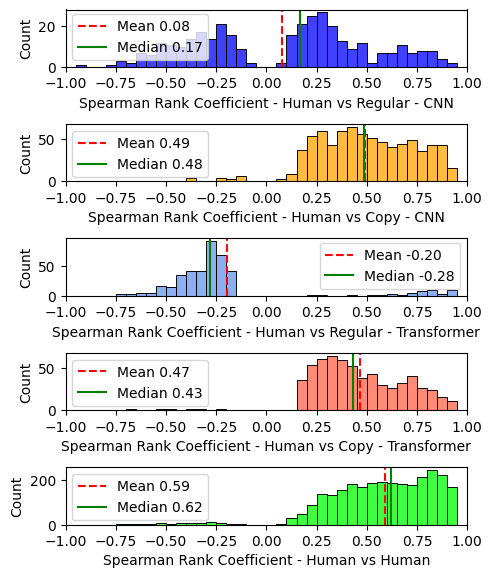

In [28]:
plt.style.use(STYLE_PATH_DEFAULT)

prefixes = [
    'AVG_', 'COPY_AVG_'
]

corr_coefficients = [
    'spearman',
]

attention_info = [
    {'prefix': 'AVG_',
     'coeff': 'spearman',
     'color': 'blue',
     'label': f'Spearman Rank Coefficient - Human vs Regular - {ALLAMANIS_MODEL_NAME}',
     'title': '',
     'dataset': df_comparative_study_allamanis
    },
    
    {'prefix': 'COPY_AVG_',
     'coeff': 'spearman',
     'color': 'orange',
     'label': f'Spearman Rank Coefficient - Human vs Copy - {ALLAMANIS_MODEL_NAME}',
     'title': '',
     'dataset': df_comparative_study_allamanis
    },
    
    {'prefix': 'REGULAR_AVG_TRANSF_',
     'coeff': 'spearman',
     'color': 'cornflowerblue',
     'label': f'Spearman Rank Coefficient - Human vs Regular - {TRANSFORMER_MODEL_NAME}',
     'title': '',
     'dataset': df_comparative_study_transformer
    },
    
    {'prefix': 'COPY_TRANSF_',
     'coeff': 'spearman',
     'color': 'tomato',
     'label': f'Spearman Rank Coefficient - Human vs Copy - {TRANSFORMER_MODEL_NAME}',
     'title': '',
     'dataset': df_comparative_study_transformer
    },
    
    {'prefix': 'HH_',
     'coeff': 'spearman',
     'color': 'lime',
     'label': 'Spearman Rank Coefficient - Human vs Human',
     'title': '',
     'dataset': df_human_pairs
    },
]

n_columns = 1
n_rows = len(attention_info)
# axes histograms
fig_hist, axes_hist = plt.subplots(n_rows, n_columns, squeeze=False)
fig_hist.set_size_inches(5, 1.2 * n_rows)


plt.tight_layout(pad=2)

CUTOFF_P_VALUE = 0.05

for i, info in enumerate(attention_info):
        
    prefix = info['prefix']
    corr_coef = info['coeff']

    c_ax = axes_hist[i][0]

    print(prefix + corr_coef)

    df = info['dataset']
    #df = df[df['n_tokens'] > 80]
    df = df[df[prefix + corr_coef + '_p'] <= CUTOFF_P_VALUE]
    mean = df[prefix + corr_coef].mean()
    median = df[prefix + corr_coef].median()

    sns.histplot(x=prefix + corr_coef, 
                 # for strata of p-values
                 #hue=prefix + corr_coef + '_p_class',
                 #multiple="stack",
                 #hue="project_name",
                 color=info['color'],
                 #palette=plt.get_cmap('Reds'),
                 bins=np.arange(-1,1,0.05),
                 data=df,
                 ax=c_ax
    )

    c_ax.set_title(info['title'])
    c_ax.set_xlim((-1,+1))
    c_ax.set_xlabel(info['label'])
    c_ax.axvline(mean, color='r', linestyle='--')
    c_ax.axvline(median, color='g', linestyle='-')
    c_ax.legend(
        {f'Mean {mean:.2f}': mean, f'Median {median:.2f}': median},
        loc='best'
    )
    
    out_eps_name = OUT_PlOT_FOLDER + '/Fig3_RQ1_Correlation_Human_vs_Machine.pdf'
    fig_hist.savefig(out_eps_name, format='pdf', bbox_inches='tight')

# RQ 2 - Distribution of Attention across Tokens
This recreate Figure 4 of the paper: Median value of normalized attention profiles across all studied
methods.

In [29]:
# FUNCTIONS TO COMPUTE THE NORMALIZED ATTENTION

def get_attention_profile(attention_weights):
    sorted_weights = list(sorted(attention_weights))
    # force positive
    sorted_weights = [np.abs(w) for w in sorted_weights]
    max_value = np.max(sorted_weights)
    if max_value == 0:
        y = sorted_weights
    else:
        y = sorted_weights / max_value 
    
    if np.min(y) < 0:
        print(y)
    n_datapoints = len(y)
    increment = 1 / (n_datapoints-1)
    x = np.arange(0, 1, increment)
    if len(x) < len(y):
        x = np.append(x, 1)
    if len(x) == len(y):
        x[-1] = 1
    return pd.Series([x, y])

def get_quantile_difference(attention_weights, q_min=10, q_max=90):
    np_weights = np.array(attention_weights)
    return np.percentile(a=np_weights, q=q_max) - np.percentile(a=np_weights, q=q_min)

config_steps = [
    {'start': 0, 'end': 20},
    {'start': 10, 'end': 90},
    {'start': 95, 'end': 100}
]

def normalized_profile(profile):
    return np.quantile(profile, q=np.arange(0,1.01,0.01))

def compute_profile(df, columns=['att_vector_w_click']):
    '''Compute the profile for a specific column.'''
    df = deepcopy(df)
    for column in columns:
        df[[column + '_profile_x', column + '_profile_y']] = \
            df.apply(
            lambda row: get_attention_profile(row[column]),
            axis=1
        )
        df[[column + '_profile_y_norm']] = \
            df.apply(
            lambda row: normalized_profile(row[column + '_profile_y']),
            axis=1
        )
        df[[column + '_profile_x_norm']] = \
            df.apply(
            lambda row: np.arange(0,1.01,0.01),
            axis=1
        )
        for step in config_steps:
            s = step['start']
            e = step['end']
            df[column + '_increment_' + str(s) + '_' + str(e)] = \
                df.apply(
                lambda row: get_quantile_difference(row[column + '_profile_y'],
                                                    q_min=s, q_max=e),
                axis=1
            )
    return df


df_attention_profiles_allamanis = \
    compute_profile(df=df_comparative_study_allamanis,
                    columns=['att_vector_avg',
                             'copy_att_vector_avg',
                             'att_vector_w_click'])

df_attention_profiles_transformer = \
    compute_profile(df=df_comparative_study_transformer,
                    columns=['att_transformers_regular_avg',
                             'att_transformers_copy'])

def color_position(color_name):
    if color_name == 'red':
        return 0
    if color_name == 'green':
        return 1
    if color_name == 'blue':
        return 2
    return 0

def reduce_color(color_rgb, percentage):
    color_rgb = deepcopy(color_rgb)
    for i, value in enumerate(color_rgb[:3]):
        color_rgb[i] = color_rgb[i] * percentage
    return color_rgb

def plot_profile(df, column_name='att_vector_w_click', 
                 pvalue_column_name=None,
                 base_color = 'lightgray',
                 percentile_color = 'red',
                 shade_based_on_length=True,
                 longer_on_top=True,
                 pvalue_cutoff=None, 
                 percentiles=[25, 50, 75],
                 ax=None, ax_colorbar=None,
                 force_color_bar_deletion=True,
                 show_all_functions=False,
                 percentile_marker='>',
                 legend_percentile=None):
    '''Plot profile of some column.'''
    if pvalue_cutoff is not None and pvalue_column_name is not None:
        df = df[df[pvalue_column_name] <=  pvalue_cutoff]
        print(f'COL: {column_name} - PVALUE_COL: {pvalue_column_name}')
        print(f'Filtering only data wih p-value lower than {pvalue_cutoff}')
    print(f'Data considered: {len(df)}')
    
    if ax is None or ax_colorbar is None:
        fig, axes = plt.subplots(1, 2)   
        ax = axes[0]
        ax_colorbar = axes[1]
        
    dynamic_legend_percentile = False
    if legend_percentile is None:
        dynamic_legend_percentile = True 
        
    max_length = df['n_tokens'].max()
    
    base_color_rgb = list(matplotlib.colors.to_rgba(base_color, alpha=1))
    all_vectors = []
    # plot al lines
    for row in df.iterrows():
        content = row[1]
        if shade_based_on_length:
            color = \
                reduce_color(
                    color_rgb=base_color_rgb, 
                    percentage=1 - content['n_tokens'] / max_length)
        else:
            color = base_color
        if longer_on_top:
            zorder = content['n_tokens']
        all_vectors += [content[column_name + '_profile_y_norm']]
        if show_all_functions:
            ax.plot(content[column_name + '_profile_x_norm'],
                    content[column_name + '_profile_y_norm'],
                    zorder=zorder,
                    color=color)
    # plot percentiles of the group trend
    matrix_vectors = np.vstack(all_vectors)    
    for p in percentiles:
        vector_percentile = \
            np.percentile(matrix_vectors, q=p, axis=0)
        print(len(vector_percentile))
        style = 'solid'
        marker = None
        
        if dynamic_legend_percentile:
            legend_percentile = column_name + '_' + str(p)
        
        if p == 50:
            #style = 'dashdot'
            style = 'solid'
            marker = percentile_marker
        ax.plot(
            np.arange(0,1.01,0.01),
            vector_percentile,
            zorder=max_length,
            color=percentile_color,
            marker=marker,
            linestyle=style,
            linewidth=2,
            label=legend_percentile)
    ax.grid()
    # limits
    ax.set_ylim((0,1))
    ax.set_xticks(np.arange(0,1.1, 0.5))
    ax.set_xticklabels([
        'Token with\nleast attention\n(0%-percentile)', 
        'in between\n(50%-percentile)', 
        'Token with\nmost attention\n(100%-percentile)'
    ])
    # labels
    if show_all_functions:
        legend = \
            ax.legend(
                title=f'Each line is one of {len(df)} functions',
                loc='upper left')
        legend.set_zorder(max_length + 1)
    ax.set_ylabel(
        'Normalized Attention Score', fontsize=14)
    # create colormap
    if show_all_functions:
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [base_color, 'black'])
        norm = matplotlib.colors.Normalize(vmin=0, vmax=max_length)
        cb1 = matplotlib.colorbar.ColorbarBase(
            ax_colorbar, cmap=cmap,
            norm=norm,
            orientation='vertical')
        cb1.set_label('Function length (no. tokens)')
    else:
        if force_color_bar_deletion:
            plt.delaxes(ax_colorbar)

Regular Attention - CNN
Data considered: 1508
101
Copy Attention - CNN
Data considered: 1508
101
Regular Attention - Transformer
Data considered: 1508
101
Copy Attention - Transformer
Data considered: 1508
101
Human Attention
Data considered: 1508
101


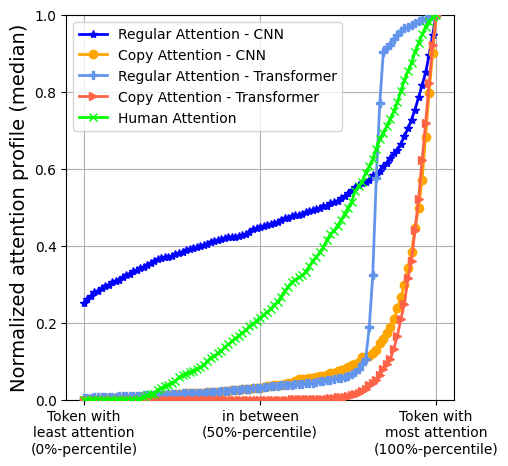

<Figure size 640x480 with 0 Axes>

In [30]:
plt.style.use(STYLE_PATH_DEFAULT)

attention_info = [
    {'col_name': 'att_vector_avg', 
     'color': 'blue', 
     'desc': f'Regular Attention - {ALLAMANIS_MODEL_NAME}', 
     'short': 'Regular',
     'marker': '*',
     'dataset': df_attention_profiles_allamanis,
    },
    
    {'col_name': 'copy_att_vector_avg', 
     'color': 'orange', 
     'desc': f'Copy Attention - {ALLAMANIS_MODEL_NAME}', 
     'short': 'Copy',
     'marker': 'o',
     'dataset': df_attention_profiles_allamanis},
    
    {'col_name': 'att_transformers_regular_avg', 
     'color': 'cornflowerblue', 
     'desc': f'Regular Attention - {TRANSFORMER_MODEL_NAME}', 
     'short': 'Reguar - Tranformer',
     'marker': 'P',
     'dataset': df_attention_profiles_transformer}, 
    
    {'col_name': 'att_transformers_copy', 
     'color': 'tomato', 
     'desc': f'Copy Attention - {TRANSFORMER_MODEL_NAME}', 
     'short': 'Copy - Tranformer',
     'marker': '>',
     'dataset': df_attention_profiles_transformer},   
    
    {'col_name': 'att_vector_w_click', 
     'color': 'lime', 
     'desc': 'Human Attention', 
     'short': 'Human',
     'marker': 'x',
     'dataset': df_attention_profiles_allamanis},
]

# NO COLORBARS
# fig_profiles = plt.figure(constrained_layout=True, figsize=(7,7))
# widths = [4, 0.001, 4, 0.001]
# WITH COLORBARS
fig_all_in_one, ax_all = plt.subplots(1, 1, figsize=(5,5))
fig_fake, fake_ax = plt.subplots(1, 1)

for i, info in enumerate(attention_info):
    ax_all.set_title(info['desc'])
    df = info['dataset']
    print(info['desc'])
    plot_profile(
        df=df,
        column_name=info['col_name'],
        percentile_color=info['color'],
        shade_based_on_length=True,
        longer_on_top=True,
        show_all_functions=False,
        percentile_marker=info['marker'],
        percentiles=[50],
        ax=ax_all, ax_colorbar=fake_ax,
        force_color_bar_deletion=False,
        legend_percentile=info['desc'])
ax_all.set_title('')
ax_all.set_ylabel('Normalized attention profile (median)')
ax_all.legend()
fig_fake.delaxes(fake_ax)

#plt.tight_layout()
out_eps_name = OUT_PlOT_FOLDER + '/Fig4_RQ2_Normalized_Attention_Profile.pdf'
fig_all_in_one.savefig(out_eps_name, format='pdf', bbox_inches='tight')

# RQ 3 - Category Based Analysis
This reproduce Figure 5 of the paper: Distance from uniformity (DFU) for different token categories.

18096
18096
We dropped 0 null values
18096
18096
We dropped 0 null values
18096
18096
We dropped 0 null values
18096
18096
We dropped 0 null values
18096
18096
We dropped 0 null values
90480


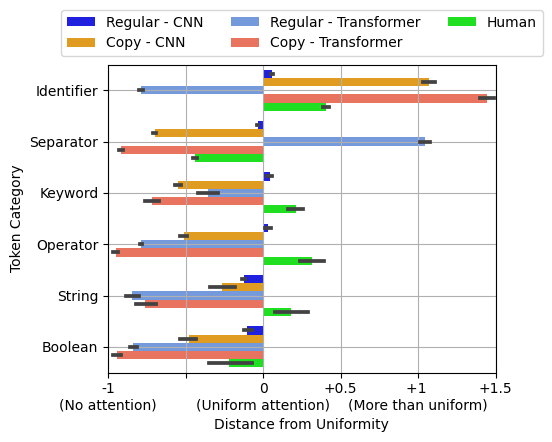

In [31]:
def categorize(row, cmp, col_attention='att_vector_w_click', only_first_k_tokens=None):
    '''Compute the percentage of attention per category.'''
    tokens_category = \
        [t['kind'] #if t['text'] != '{' and t['text'] != '}' else 'CurlyBrackets'
         for t in row['tokens_in_code']]
    # consider only the first tokens (in case of transformer)
    if ((only_first_k_tokens is not None) and 
        (len(row['tokens_in_code']) > only_first_k_tokens)):
        # print(f"{row['original_name']} capped (originally {row['n_tokens']})")
        tokens_category = \
            [t['kind'] #if t['text'] != '{' and t['text'] != '}' else 'CurlyBrackets'
             for t in row['tokens_in_code'][:only_first_k_tokens]]
    scores = row[col_attention]
    #if (len(tokens_category) != len(scores)):
        #print(row['uuid'], ' error different number of tokens and scores')
    if (len(tokens_category) + 2 == len(scores)):
        #print('dropped first and last scores for the special keywords')
        scores = scores[1:-1]
    df_row = pd.DataFrame({'scores': scores, 'category': tokens_category})
    df_grouped = df_row.groupby(by='category').sum()
    all_sum = df_grouped['scores'].sum()
    df_grouped['scores'] = df_grouped['scores'] / all_sum
    dict_pct_attention = dict(df_grouped['scores'])
    #categories_present = df_grouped.index
    dict_pct_baseline = dict(Counter(tokens_category))
    
    all_categories = cmp.get_token_categories()
    
    triplet = list(zip(
        all_categories, 
        [dict_pct_attention.get(cat, 0) 
         for cat in all_categories
        ],
        [dict_pct_baseline.get(cat, 0) / len(tokens_category)
         for cat in all_categories
        ]))
    return triplet

# DIAGRAM PRODUCTION
attention_info = [
    {'col_name': 'att_vector_avg', 'color': 'blue', 
     'desc': 'Convolutional Attention', 'short': f'Regular - {ALLAMANIS_MODEL_NAME}',
     'prefix': 'REG',
     'dataset': df_comparative_study_allamanis,
     'only_first_k_tokens': None
    },
    
    {'col_name': 'copy_att_vector_avg', 'color': 'orange', 
     'desc': 'Copy Attention', 'short': f'Copy - {ALLAMANIS_MODEL_NAME}',
     'prefix': 'COP',
     'dataset': df_comparative_study_allamanis,
     'only_first_k_tokens': None
    },    
    
    {'col_name': 'att_transformers_regular_avg', 'color': 'cornflowerblue', 
     'desc': 'Transformer Attention', 'short': f'Regular - {TRANSFORMER_MODEL_NAME}',
     'prefix': 'REG_TRANF',
     'dataset': df_comparative_study_transformer,
     'only_first_k_tokens': 150
    },
    
    {'col_name': 'att_transformers_copy', 'color': 'tomato', 
     'desc': 'Transformer Attention', 'short': f'Copy - {TRANSFORMER_MODEL_NAME}',
     'prefix': 'COPY_TRANSF',
     'dataset': df_comparative_study_transformer,
     'only_first_k_tokens': 150
    },
    
    {'col_name': 'att_vector_w_click', 'color': 'lime', 
     'desc': 'Human Attention', 'short': 'Human',
     'prefix': 'HUM',
     'dataset': df_comparative_study_allamanis,
     'only_first_k_tokens': None
    }  
]

dfs = []

for i, info in enumerate(attention_info):
    df = info['dataset']
    # enrich with percentage of attention per token category
    category_col_name = 'pct_categories_' + info['prefix']
    df[category_col_name] = \
        df.apply(lambda row: categorize(
        row, cmp=cmp_allamanis, 
        col_attention=info['col_name'],
        only_first_k_tokens=info['only_first_k_tokens']), axis=1)
    df_categories_pct_attention = df.explode(category_col_name)
    n_null = df_categories_pct_attention[category_col_name].isna().sum() 
    print(len(df_categories_pct_attention))
    df_categories_pct_attention = \
        df_categories_pct_attention[
            ~df_categories_pct_attention[category_col_name].isna()]
    print(len(df_categories_pct_attention))
    
    print(f'We dropped {n_null} null values')
    df_categories_pct_attention[['uuid', 'randomcode', category_col_name]].head()
    df_categories_pct_attention['category'] = \
        df_categories_pct_attention[category_col_name].apply(
            lambda c: c[0]
    )
    df_categories_pct_attention['pct_attention_cat'] = \
        df_categories_pct_attention[category_col_name].apply(
            lambda c: c[1]
    )
    df_categories_pct_attention['pct_natural_cat'] = \
        df_categories_pct_attention[category_col_name].apply(
            lambda c: c[2]
    )
    df_categories_pct_attention['pct_diff_att_natural'] = (
        df_categories_pct_attention['pct_attention_cat'] -
        df_categories_pct_attention['pct_natural_cat']
    )
    
    df_categories_pct_attention['relative_pct_diff_att_natural'] = (
        100 * ((df_categories_pct_attention['pct_attention_cat'] -
        df_categories_pct_attention['pct_natural_cat']) / df_categories_pct_attention['pct_natural_cat'])
    )
    
    #axes[i][0].set_title(info['short'])
    #sns.barplot(
    #    data=df_categories_pct_attention,
    #    y='category',
    #    x='pct_attention_cat',
    #    ax=axes[i][0]
    #)
    df_categories_pct_attention['PROVENANCE'] = info['short']
    dfs.append(deepcopy(df_categories_pct_attention))
    
#plt.tight_layout()
#plt.show()

# change percentage format
df_all = pd.concat(dfs, axis=0)
df_all['relative_pct_diff_att_natural'] = \
    df_all['relative_pct_diff_att_natural'].astype(float) / 100
print(len(df_all))

plt.style.use(STYLE_PATH_DEFAULT)
fig, axes = plt.subplots(1, 1, figsize=(5, 4), squeeze=False)#, #sharey=True)
c_ax = axes[0][0]

sns.barplot(
    data=df_all,
    y='category',
    x='relative_pct_diff_att_natural',
    hue='PROVENANCE',
    ax=c_ax,
    palette=[
        info['color'] for info in attention_info
    ],
    order=['Identifier', 'Separator', 'Keyword', 'Operator', 'String', 'Boolean']
)

fmt = lambda y, pos: ('%+.1f' if y > 0 else '%.1f') % y
c_ax.xaxis.set_major_formatter(mtick.FuncFormatter(fmt))
c_ax.set_xlim((-1,+1.5))
c_ax.set_xticks(np.arange(-1,2, 0.5))
c_ax.set_xticklabels([
    '-1\n(No attention)', 
    '', 
    '0\n(Uniform attention)',
    '+0.5',
    '+1 \n(More than uniform)',
    '+1.5'
])


c_ax.grid(axis='both')
c_ax.set_xlabel('Distance from Uniformity')
c_ax.set_ylabel('Token Category')
c_ax.legend(title='Attention')

c_ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
            ncol=3)


out_eps_name = OUT_PlOT_FOLDER + '/Fig5_RQ3_Distance_from_Uniformity.pdf'
fig.savefig(out_eps_name, format='pdf', bbox_inches='tight')

## Extra: Distance From Uniformity for specific categories
Focus on the two types of tokens:
- curly brackets
- dot, comma and open parenthesis

In [32]:
# HELPER FUNCTION
def categorize_tokens_vs_rest(row, cmp, 
                              admitted_tokens=['{','}'], 
                              name_for_custom_token_list='CurlyBrackets', 
                              col_attention='att_vector_w_click', only_first_k_tokens=None):
    '''Compute the percentage of attention per curly brackets vs rest.'''
    tokens_category = \
        [name_for_custom_token_list if t['text'] in admitted_tokens else 'Rest'
         for t in row['tokens_in_code']]
    # consider only the first tokens (in case of transformer)
    if ((only_first_k_tokens is not None) and 
        (len(row['tokens_in_code']) > only_first_k_tokens)):
        tokens_category = tokens_category[:only_first_k_tokens]
    scores = row[col_attention]
    if (len(tokens_category) + 2 == len(scores)):
        #print('dropped first and last scores for the special keywords')
        scores = scores[1:-1]
    df_row = pd.DataFrame({'scores': scores, 'category': tokens_category})
    df_grouped = df_row.groupby(by='category').sum()
    all_sum = df_grouped['scores'].sum()
    df_grouped['scores'] = df_grouped['scores'] / all_sum
    dict_pct_attention = dict(df_grouped['scores'])
    #categories_present = df_grouped.index
    dict_pct_baseline = dict(Counter(tokens_category))
    
    all_categories = [name_for_custom_token_list, 'Rest']
    
    triplet = list(zip(
        all_categories, 
        [dict_pct_attention.get(cat, 0) 
         for cat in all_categories
        ],
        [dict_pct_baseline.get(cat, 0) / len(tokens_category)
         for cat in all_categories
        ]))
    return triplet

# DIAGRAM PRODUCTION
attention_info = [
    {'col_name': 'att_vector_avg', 'color': 'blue', 
     'desc': 'Convolutional Attention', 'short': f'Regular - {ALLAMANIS_MODEL_NAME}',
     'prefix': 'REG',
     'dataset': df_comparative_study_allamanis,
     'only_first_k_tokens': None
    },
    
    {'col_name': 'copy_att_vector_avg', 'color': 'orange', 
     'desc': 'Copy Attention', 'short': f'Copy - {ALLAMANIS_MODEL_NAME}',
     'prefix': 'COP',
     'dataset': df_comparative_study_allamanis,
     'only_first_k_tokens': None
    },    
    
    {'col_name': 'att_transformers_regular_avg', 'color': 'cornflowerblue', 
     'desc': 'Transformer Attention', 'short': f'Regular - {TRANSFORMER_MODEL_NAME}',
     'prefix': 'REG_TRANF',
     'dataset': df_comparative_study_transformer,
     'only_first_k_tokens': 150
    },
    
    {'col_name': 'att_transformers_copy', 'color': 'tomato', 
     'desc': 'Transformer Attention', 'short': f'Copy - {TRANSFORMER_MODEL_NAME}',
     'prefix': 'COPY_TRANSF',
     'dataset': df_comparative_study_transformer,
     'only_first_k_tokens': 150
    },
    
    {'col_name': 'att_vector_w_click', 'color': 'lime', 
     'desc': 'Human Attention', 'short': 'Human',
     'prefix': 'HUM',
     'dataset': df_comparative_study_allamanis,
     'only_first_k_tokens': None
    } 
]

#fig, axes = plt.subplots(3, 1, figsize=(12, 10), squeeze=False)
def get_dfs_with_categories(admitted_tokens, name_for_custom_token_list):
    """Construct the df with all the DFUs for the given custom tokens."""
    dfs = []

    for i, info in enumerate(attention_info):
        df = info['dataset']
        # enrich with percentage of attention per token category
        category_col_name = 'pct_categories_' + info['prefix']
        df[category_col_name] = \
            df.apply(lambda row: 
                categorize_tokens_vs_rest(
                    row, cmp=cmp_allamanis, 
                    admitted_tokens=admitted_tokens, 
                    name_for_custom_token_list=name_for_custom_token_list, 
                    col_attention=info['col_name'],
                    only_first_k_tokens=info['only_first_k_tokens']), 
                 axis=1
            )
        df_categories_pct_attention = df.explode(category_col_name)
        n_null = df_categories_pct_attention[category_col_name].isna().sum() 
        print(len(df_categories_pct_attention))
        df_categories_pct_attention = \
            df_categories_pct_attention[
                ~df_categories_pct_attention[category_col_name].isna()]
        print(len(df_categories_pct_attention))

        print(f'We dropped {n_null} null values')
        df_categories_pct_attention[['uuid', 'randomcode', category_col_name]].head()
        df_categories_pct_attention['category'] = \
            df_categories_pct_attention[category_col_name].apply(
                lambda c: c[0]
        )
        df_categories_pct_attention['pct_attention_cat'] = \
            df_categories_pct_attention[category_col_name].apply(
                lambda c: c[1]
        )
        df_categories_pct_attention['pct_natural_cat'] = \
            df_categories_pct_attention[category_col_name].apply(
                lambda c: c[2]
        )
        df_categories_pct_attention['pct_diff_att_natural'] = (
            df_categories_pct_attention['pct_attention_cat'] -
            df_categories_pct_attention['pct_natural_cat']
        )

        df_categories_pct_attention['relative_pct_diff_att_natural'] = (
            100 * ((df_categories_pct_attention['pct_attention_cat'] -
            df_categories_pct_attention['pct_natural_cat']) / df_categories_pct_attention['pct_natural_cat'])
        )

        #axes[i][0].set_title(info['short'])
        #sns.barplot(
        #    data=df_categories_pct_attention,
        #    y='category',
        #    x='pct_attention_cat',
        #    ax=axes[i][0]
        #)
        df_categories_pct_attention['PROVENANCE'] = info['short']
        dfs.append(deepcopy(df_categories_pct_attention))

    #plt.tight_layout()
    #plt.show()
    df_all = pd.concat(dfs, axis=0)
    print(len(df_all))
    return df_all

# EXPLORE: CURLY BRACKETS
df_all_brackets = get_dfs_with_categories(
    admitted_tokens=['{', '}'], 
    name_for_custom_token_list='CurlyBrackets')
print(df_all_brackets['category'].unique())
df_all_brackets[['uuid', 'relative_pct_diff_att_natural']].head()

# EXPLORE: DOT, COMMA AND OPEN PARENTHESIS
df_all_dot = get_dfs_with_categories(
    admitted_tokens=['.', ',', '('], 
    name_for_custom_token_list=".,(")
print(df_all_dot['category'].unique())
df_all = pd.concat([df_all_dot, df_all_brackets])


3016
3016
We dropped 0 null values
3016
3016
We dropped 0 null values
3016
3016
We dropped 0 null values
3016
3016
We dropped 0 null values
3016
3016
We dropped 0 null values
15080
['CurlyBrackets' 'Rest']
3016
3016
We dropped 0 null values
3016
3016
We dropped 0 null values
3016
3016
We dropped 0 null values
3016
3016
We dropped 0 null values
3016
3016
We dropped 0 null values
15080
['.,(' 'Rest']


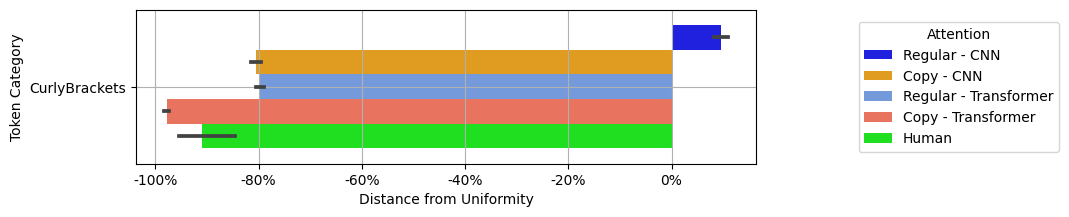

In [33]:
plt.style.use(STYLE_PATH_DEFAULT)
fig, axes = plt.subplots(1, 1, figsize=(8, 2), squeeze=False)#, #sharey=True)
c_ax = axes[0][0]

sns.barplot(
    data=df_all_brackets,
    y='category',
    x='relative_pct_diff_att_natural',
    hue='PROVENANCE',
    ax=c_ax,
    palette=[
        info['color'] for info in attention_info
    ],
    order=["CurlyBrackets"]
)

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)
c_ax.xaxis.set_major_formatter(xticks)

c_ax.grid(axis='both')
c_ax.set_xlabel('Distance from Uniformity')
c_ax.set_ylabel('Token Category')
c_ax.legend(title='Attention', loc='center right', bbox_to_anchor=(1.5, 0.5))


out_eps_name = OUT_PlOT_FOLDER + '/EXTRA_not_uniformity_for_curly_brackets.pdf'
fig.savefig(out_eps_name, format='pdf', bbox_inches='tight')

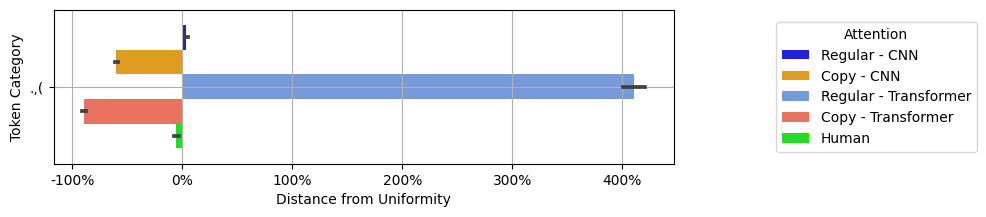

In [34]:
plt.style.use(STYLE_PATH_DEFAULT)
fig, axes = plt.subplots(1, 1, figsize=(8, 2), squeeze=False)#, #sharey=True)
c_ax = axes[0][0]


sns.barplot(
    data=df_all_dot,
    y='category',
    x='relative_pct_diff_att_natural',
    hue='PROVENANCE',
    ax=c_ax,
    palette=[
        info['color'] for info in attention_info
    ],
    order=[".,("]
    #order=['CurlyBrackets', 'Other']
)

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)
c_ax.xaxis.set_major_formatter(xticks)

c_ax.grid(axis='both')
c_ax.set_xlabel('Distance from Uniformity')
c_ax.set_ylabel('Token Category')
c_ax.legend(title='Attention', loc='center right', bbox_to_anchor=(1.5, 0.5))


out_eps_name = OUT_PlOT_FOLDER + '/EXTRA_not_uniformity_for_dot_open_parenthesis.pdf'
fig.savefig(out_eps_name, format='pdf', bbox_inches='tight')

# RQ 4.1 - Perceived Difficulty vs Model Effectiveness

(0.45133939609702267, 5.973788699478529e-14)
(0.4934351742302967, 9.542451008188087e-17)


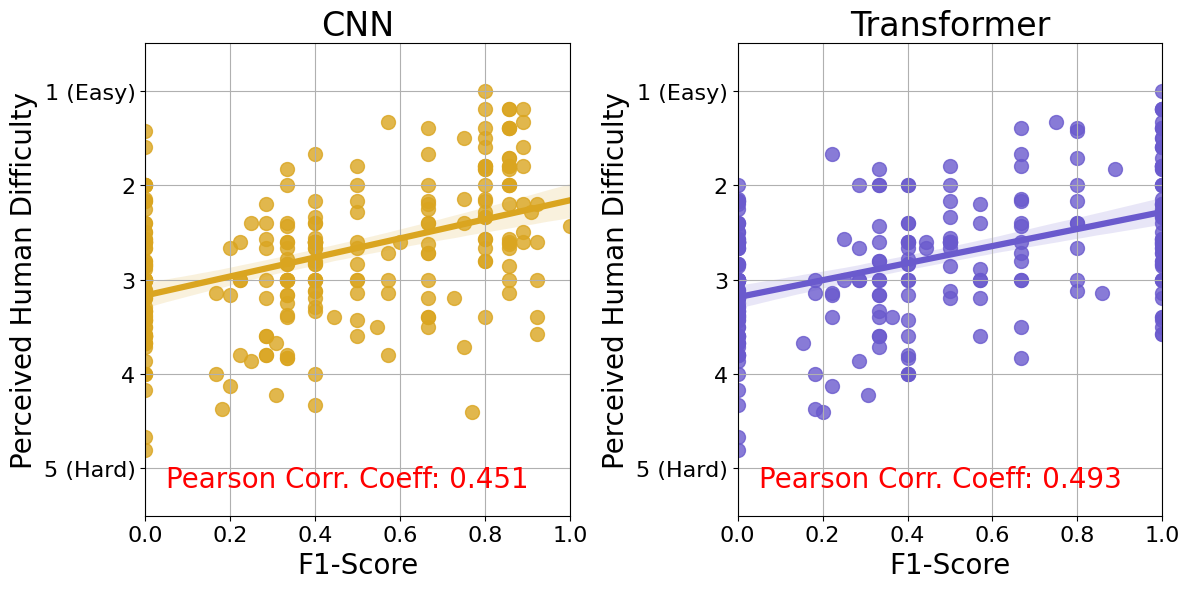

In [35]:
df = df_comparative_study_allamanis
df = df[['uuid', 'function_name', 'rating']]
df_grouped = df.groupby(by='uuid').count()
df_filtered = df_grouped[df_grouped['function_name'] >= 5]
# compute the average rate
df_average_rating = df
df_average_rating = \
    df_average_rating.groupby(by=['uuid']).agg(
        {'rating': 'mean',
         }).rename(columns={'rating': 'avg_rating'})
df_average_rating.reset_index(drop=False, inplace=True)

def plot_perceived(df, df_average_rating, ax, model_name, color):
    """Plot the perceived difficulty for a model."""
    df = df[['uuid', 'prediction_f1']]
    df = df.drop_duplicates(subset='uuid')
    df = \
        pd.merge(
            left=df,
            right=df_average_rating,
            on='uuid'
    )
    df['prediction_f1'] = df['prediction_f1'].astype(float)
    df['avg_rating'] = - df['avg_rating'].astype(float)

    sns.regplot(
        x='prediction_f1', y='avg_rating', 
        color=color,
        data=df,
        ax=ax
        )

    ax.set_ylabel('Perceived Human Difficulty')
    ax.set_xlabel(f'F1-Score')
    ax.set_title(f'{model_name}')

    pearson_correlation = \
        scipy.stats.pearsonr(
            x=df['prediction_f1'], 
            y=df['avg_rating'])
    #ax.legend(title='Number of tokens')
    ax.set_xlim((0,1))
    ax.set_ylim((-5.5,-0.5))
    ax.grid()
    ax.annotate(xy=(0.05,-5.2), xytext=(0.05,-5.2), color='red',
                text='Pearson Corr. Coeff: %.3f' % pearson_correlation[0],
                fontsize=20)
    ax.set_yticks(np.arange(-5, -.5, 1))
    ax.set_yticklabels(['5 (Hard)', '4', '3', '2', '1 (Easy)'])
    print(pearson_correlation)
    
plt.style.use(STYLE_PATH_FSE)


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax_allamanis = axes[0]
ax_transformer = axes[1]

# ALLAMANIS

plot_perceived(df=df_comparative_study_allamanis, 
               df_average_rating=df_average_rating, 
               ax=ax_allamanis, 
               model_name=ALLAMANIS_MODEL_NAME,
               color='goldenrod')

# TRANSFORMER

plot_perceived(df=df_comparative_study_transformer, 
               df_average_rating=df_average_rating, 
               ax=ax_transformer, 
               model_name=TRANSFORMER_MODEL_NAME,
               color='slateblue')

plt.tight_layout()

out_eps_name = OUT_PlOT_FOLDER + '/EXTRA_scatterplot_perceived_difficulty_vs_f1.pdf'
fig.savefig(out_eps_name, format='pdf', bbox_inches='tight')

# RQ 4.2 - Struggle on Long Functions
This reproduces Figure 7 of the paper.

[0 1]
['[0.2-0.4)', '[0.8-1]', '[0.6-0.8)', '(0-0.2]', '[0.4-0.6)']
Categories (5, object): ['(0-0.2]' < '[0.2-0.4)' < '[0.4-0.6)' < '[0.6-0.8)' < '[0.8-1]']


<ipython-input-36-733a27a019db>:73: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


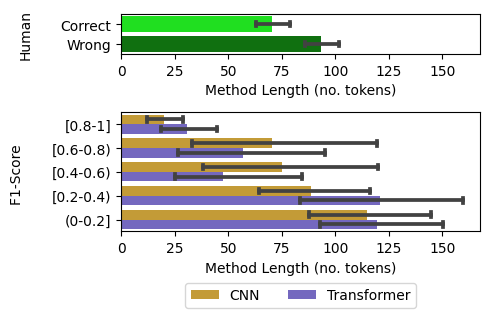

In [36]:
plt.style.use(STYLE_PATH_DEFAULT)

#fig, axes = plt.subplots(1, 3)
#fig.set_size_inches(14, 5)

fig = plt.figure(constrained_layout=True)
fig.set_size_inches(5, 3.8)
widths = [1, 2]
heights = [1,3]
spec3 = fig.add_gridspec(ncols=1, nrows=2, height_ratios=heights)
ax_human_length = fig.add_subplot(spec3[0, 0])
ax_neural_models = fig.add_subplot(spec3[1, 0], sharex=ax_human_length)

Y_LABEL = 'Method Length (no. tokens)'
ROTATION_LABELS = 60

PROPS = {
    'boxprops':{'facecolor':'none'},
    'medianprops':{'color':'red'}
}

# HUMAN

print(df_comparative_study_allamanis['is_correct'].unique())
sns.barplot(data=df_comparative_study_allamanis, 
            x='n_tokens', 
            y='is_correct',
            orient='h',
            order=[1, 0],
            palette=['lime', 'green'],
            capsize=.2,
            ax=ax_human_length)
ax_human_length.set_yticks(range(2))
ax_human_length.set_yticklabels(['Correct', 'Wrong'])
ax_human_length.set_xlabel(Y_LABEL)
ax_human_length.set_ylabel('Human', labelpad=20)
#for tick in ax_human_length.get_xticklabels():
#    tick.set_rotation(ROTATION_LABELS)

# BOTH MODELS

df_allamanis_part = df_comparative_study_allamanis[['uuid', 'f1_category', 'n_tokens']]
df_allamanis_part = df_allamanis_part.drop_duplicates(subset='uuid')
df_allamanis_part['Model'] = ALLAMANIS_MODEL_NAME

df_transformer_part = df_comparative_study_transformer[['uuid', 'f1_category', 'n_tokens']]
df_transformer_part = df_transformer_part.drop_duplicates(subset='uuid')
df_transformer_part['Model'] = TRANSFORMER_MODEL_NAME

df_both_models = pd.concat((df_allamanis_part, df_transformer_part), axis=0)
df_both_models.head()

# BOTH MODELS
print(df_both_models['f1_category'].unique())
sns.barplot(
    x='n_tokens',
    y='f1_category',
    orient='h',
    hue='Model',
    palette=['goldenrod', 'slateblue'],
            capsize=.2,
    order=['[0.8-1]', '[0.6-0.8)', '[0.4-0.6)', '[0.2-0.4)', '(0-0.2]'],
    data=df_both_models, 
    ax=ax_neural_models)
ax_neural_models.set_xlabel(Y_LABEL)
ax_neural_models.set_ylabel('F1-Score ', labelpad=20)
#for tick in ax_neural_models.get_xticklabels():
    #tick.set_rotation(ROTATION_LABELS)
ax_neural_models.legend(
    loc='lower center', bbox_to_anchor=(0.5, -.7), ncol=2)


plt.tight_layout()

out_eps_name = OUT_PlOT_FOLDER + '/Fig7_RQ4_Method_Length_and_Performance.pdf'
fig.savefig(out_eps_name, format='pdf', bbox_inches='tight')

# RQ 4 - Comparison of Model Effectiveness
This recreates figure 8 of the paper.

In [37]:
plt.style.use(STYLE_PATH_DEFAULT)

cmp_allamanis.compute_model_performance()
df_tmp_allamanis = cmp_allamanis.get_compare_df()

df_perf_comaprison = pd.merge(
    left=df_comparative_study_transformer[['prediction_f1', 'uuid', 'handmade_category']]\
        .drop_duplicates()\
        .rename(columns={'prediction_f1': 'f1_transformer'}),
    right=df_tmp_allamanis[['prediction_f1', 'uuid']]\
        .drop_duplicates()\
        .rename(columns={'prediction_f1': 'f1_allamanis'}),
    on='uuid'
)

def assign_performance(row):
    if row['is_correct']:
        return 'Correct'
    if row['error_on_tfidf']:
        return 'Pseudo-correct'
    if row['error_on_random']:
        return 'Wrong'

df = df_human
df['human_performance'] = df.apply(
    lambda row: assign_performance(row),
    axis=1
)
print(df['human_performance'].unique())

df_performance_human = df

x, y, hue = "human_performance", "Prop", "handmade_category"
hue_order = ['getter', 'setter', 'checker', 'test', 'other']

prop_df = (df_performance_human[x]
           .groupby(df_performance_human[hue])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

INFO:attention-comparer: 1700 records in the intersection.
INFO:attention-comparer: Each of them with at least 5 annotators.


['Pseudo-correct' 'Correct' 'Wrong']


<ipython-input-38-59d07a748fa2>:71: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(1.15)


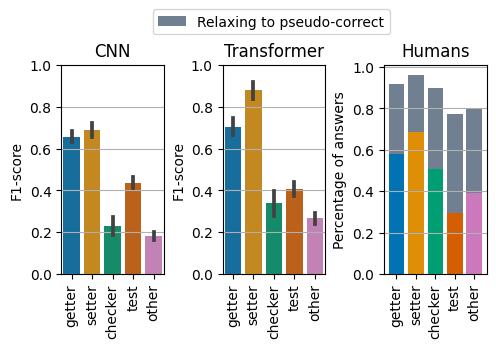

In [38]:
labels = ['getter', 'setter', 'checker', 'test', 'other']
perc_correct = [
    prop_df[
        (prop_df['handmade_category'] == l) &
        (prop_df['human_performance'] == 'Correct')
    ]['Prop'].iloc[0]
    for l in labels
]
perc_pseudo_correct = [
    prop_df[
        (prop_df['handmade_category'] == l) &
        (prop_df['human_performance'] == 'Pseudo-correct')
    ]['Prop'].iloc[0]
    for l in labels
]
perc_wrong = [
    prop_df[
        (prop_df['handmade_category'] == l) &
        (prop_df['human_performance'] == 'Wrong')
    ]['Prop'].iloc[0]
    for l in labels
]

def create_human_performance_barplot(ax, color_palette_name='colorblind'):
    width = .8      # the width of the bars: can also be len(x) sequence

    PSEUDO_COLOR = 'slategrey'
    
    my_cmap = sns.color_palette(color_palette_name, as_cmap=True)
    ax.bar(labels, perc_pseudo_correct, width, 
           color=PSEUDO_COLOR, 
           bottom=perc_correct,
           label='Pseudo-correct')
    ax.bar(labels, perc_correct,  
           width, 
           color=my_cmap[:5],
           label='Correct')

    #ax.bar(labels, 
    #       [-p for p in perc_wrong], 
    #       width, 
    #       color='black',
    #       label='Wrong')

    ax.set_ylabel('Percentage of answers')
    #ax.axhline(0, c='red', linestyle='--')
    legend_elements = []
    legend_elements += [
        Patch(facecolor=PSEUDO_COLOR, label='Relaxing to pseudo-correct'),
    ]
    #legend_elements += [
    #    Patch(facecolor=c, label=f'Correct ({l})')
    #    for c, l in zip(my_cmap[:5], labels)
    #]
    #legend_elements += [
    #    Patch(facecolor='black', label='Wrong')
    #]
    ax.legend(
        loc='upper center', bbox_to_anchor=(-1.1, 1.3),
        handles=legend_elements,  ncol=1
    )
    return ax

plt.style.use(STYLE_PATH_DEFAULT)
fig, axes = plt.subplots(1, 3, figsize=(5, 2.7))

ax_allamanis = axes[0]
ax_transformer = axes[1]
ax_human = axes[2]

plt.tight_layout(1.15)

# Transformer
sns.barplot(
    data=df_comparative_study_transformer,
    x='handmade_category',
    y='prediction_f1',
    order=['getter', 'setter', 'checker', 'test', 'other'],
    ax=ax_transformer,
    palette=sns.color_palette('colorblind')
)
ax_transformer.set_title(TRANSFORMER_MODEL_NAME)
ax_transformer.set_ylim((0,1))
ax_transformer.grid(axis='y')
ax_transformer.set_xlabel('')
ax_transformer.set_ylabel('F1-score')
for tick in ax_transformer.get_xticklabels():
    tick.set_rotation(90)

# Allamanis
sns.barplot(
    data=df_comparative_study_allamanis,
    x='handmade_category',
    y='prediction_f1',
    order=['getter', 'setter', 'checker', 'test', 'other'],
    ax=ax_allamanis,
    palette=sns.color_palette('colorblind')
)
ax_allamanis.set_title(ALLAMANIS_MODEL_NAME)
ax_allamanis.set_ylim((0,1))
ax_allamanis.grid(axis='y')
ax_allamanis.set_xlabel('')
ax_allamanis.set_ylabel('F1-score')
for tick in ax_allamanis.get_xticklabels():
    tick.set_rotation(90)

# HUMAN
create_human_performance_barplot(ax=ax_human)
ax_human.set_title('Humans')
ax_human.grid(axis='y')
for tick in ax_human.get_xticklabels():
    tick.set_rotation(90)
    
out_eps_name = OUT_PlOT_FOLDER + '/Fig8_RQ4_Performance_Categories.pdf'
fig.savefig(out_eps_name, format='pdf', bbox_inches='tight')

# RQ 5 - Human Correlation vs Model Effectiveness
This produces Figure 9 of the paper.

347 points considered for AVG_spearman
(0.18590746038844821, 0.000499601952787562)
772 points considered for COPY_AVG_spearman
(0.1946755204926383, 4.96603967592115e-08)
412 points considered for REGULAR_AVG_TRANSF_spearman
(0.40264006799910834, 1.7276518769335815e-17)
619 points considered for COPY_TRANSF_spearman
(0.26232733581986367, 3.359380575286765e-11)


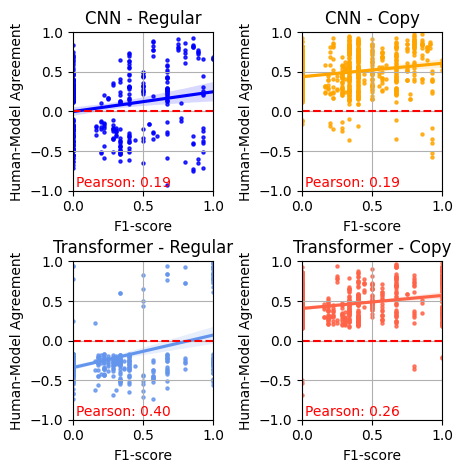

In [39]:
plt.style.use(STYLE_PATH_DEFAULT)
CUTOFF = 0.05

def draw_ax_performace(info, target_ax):
    """Get the axes f1 vs correlation measure."""
    # TRANSFORMER - REGULAR

    df = info['dataset']
    prefix = info['prefix']
    coeff = info['coeff']
    color = info['color']
    title = info['title']
    label = info['label']
    df = df[df[prefix + coeff + '_p'] < CUTOFF]
    #df = df[df['prediction_f1'] > 0]

    sns.regplot(
        data=df,
        x='prediction_f1',
        y=prefix + coeff,
        #hue='is_correct',
        color=color,
        marker='o',  # info['marker'],
        ax=target_ax,
        scatter_kws={'s':5}
    )
    target_ax.set_xlim((0,1))
    target_ax.set_ylim((-1,1))
    target_ax.grid()
    target_ax.set_ylabel(label)
    target_ax.set_xlabel('F1-score')
    target_ax.axhline(0, linestyle='--', color='red')
    target_ax.set_title(title)

    pearson_correlation = \
        sci.stats.pearsonr(
            x=df['prediction_f1'], 
            y=df[prefix + coeff])
    target_ax.annotate(xy=(0.02,-0.95), xytext=(0.02,-0.95), 
                text='Pearson: %.2f' % pearson_correlation[0],
                color='red')
    print(f'{len(df)} points considered for {prefix}{coeff}')
    print(pearson_correlation)
    
fig, axes = plt.subplots(2, 2, figsize=(5, 5))

flattened_axes = list(axes.reshape((1, -1)))[0]

attention_info = [
    {'prefix': 'AVG_',
     'coeff': 'spearman',
     'color': 'blue',
     'marker': '*',
     'label': 'Human-Model Agreement',
     'title': f'{ALLAMANIS_MODEL_NAME} - Regular',
     'dataset': df_comparative_study_allamanis
    },
    
    {'prefix': 'COPY_AVG_',
     'coeff': 'spearman',
     'color': 'orange',
     'marker': 'o',
     'label': 'Human-Model Agreement',
     'title': f'{ALLAMANIS_MODEL_NAME} - Copy',
     'dataset': df_comparative_study_allamanis
    },
    
    {'prefix': 'REGULAR_AVG_TRANSF_',
     'coeff': 'spearman',
     'color': 'cornflowerblue',
     'marker': 'P',
     'label': 'Human-Model Agreement',
     'title': f'{TRANSFORMER_MODEL_NAME} - Regular',
     'dataset': df_comparative_study_transformer
    },
    
    {'prefix': 'COPY_TRANSF_',
     'coeff': 'spearman',
     'color': 'tomato',
     'marker': '>',
     'label': 'Human-Model Agreement',
     'title': f'{TRANSFORMER_MODEL_NAME} - Copy',
     'dataset': df_comparative_study_transformer
    },
]

plt.tight_layout(pad=3)

for info, c_ax in zip(attention_info, flattened_axes):
    draw_ax_performace(info=info, target_ax=c_ax)
    
out_eps_name = OUT_PlOT_FOLDER + '/Fig9_RQ5_Agreement_vs_Performance.pdf'
fig.savefig(out_eps_name, format='pdf', bbox_inches='tight')

## Correlation when model is successful (F1-score >= 0.5)
The mean of the following figure is used in Table 2 of the paper.

AVG_spearman
COPY_AVG_spearman
REGULAR_AVG_TRANSF_spearman
COPY_TRANSF_spearman


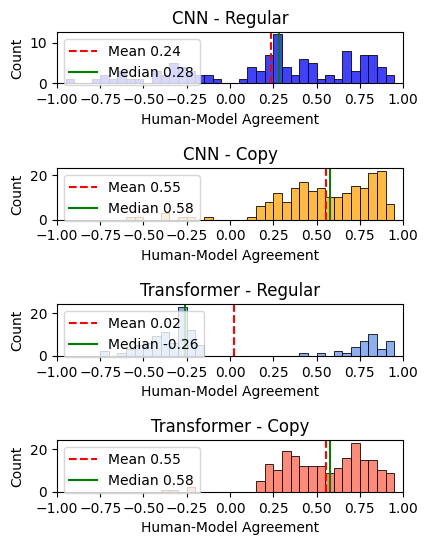

In [40]:
plt.style.use(STYLE_PATH_DEFAULT)
n_columns = 1
n_rows = len(attention_info)
# axes histograms
fig_hist, axes_hist = plt.subplots(n_rows, n_columns, squeeze=False)
fig_hist.set_size_inches(5, 1.5 * n_rows)


plt.tight_layout(pad=4)

CUTOFF_P_VALUE = 0.05

for i, info in enumerate(attention_info):
        
    prefix = info['prefix']
    corr_coef = info['coeff']

    c_ax = axes_hist[i][0]

    print(prefix + corr_coef)

    df = info['dataset']
    if info['prefix'] != 'HH_':
        df = df[df['prediction_f1'] >= 0.5]
    df = df[df[prefix + corr_coef + '_p'] <= CUTOFF_P_VALUE]
    mean = df[prefix + corr_coef].mean()
    median = df[prefix + corr_coef].median()

    sns.histplot(x=prefix + corr_coef, 
                 # for strata of p-values
                 #hue=prefix + corr_coef + '_p_class',
                 #multiple="stack",
                 #hue="project_name",
                 color=info['color'],
                 #palette=plt.get_cmap('Reds'),
                 bins=np.arange(-1,1,0.05),
                 data=df,
                 ax=c_ax
    )

    c_ax.set_title(info['title'])
    c_ax.set_xlim((-1,+1))
    c_ax.set_xlabel(info['label'])
    c_ax.axvline(mean, color='r', linestyle='--')
    c_ax.axvline(median, color='g', linestyle='-')
    c_ax.legend(
        {f'Mean {mean:.2f}': mean, f'Median {median:.2f}': median},
        loc='upper left'
    )
    
    out_eps_name = OUT_PlOT_FOLDER + '/Table2_Correlation_Human_vs_Machine_F1_greater_0.5.pdf'
    fig_hist.savefig(out_eps_name, format='pdf', bbox_inches='tight')


# EXTRA - Plotting of Attention Maps Figures
Reproduce part of figure 2 showing the regular convolutional model attention and the human attention.

filter uuid
['ee9be781fc52e43c068b8f02ca2a45c8']
**************************************************  CODE:  ee9be781fc52e43c068b8f02ca2a45c8
testsendtosynchronousdestination -> ['test', 'destination', 'destination', '%END%', '%END%', '%END%']
 -  filter asset tag names asset entries
 -  replace with synchronous destination
 - send
 - set reverse
 - set social activity setting service
 - test send to async destination
 - test send to synchronous destination
<class 'PIL.Image.Image'>


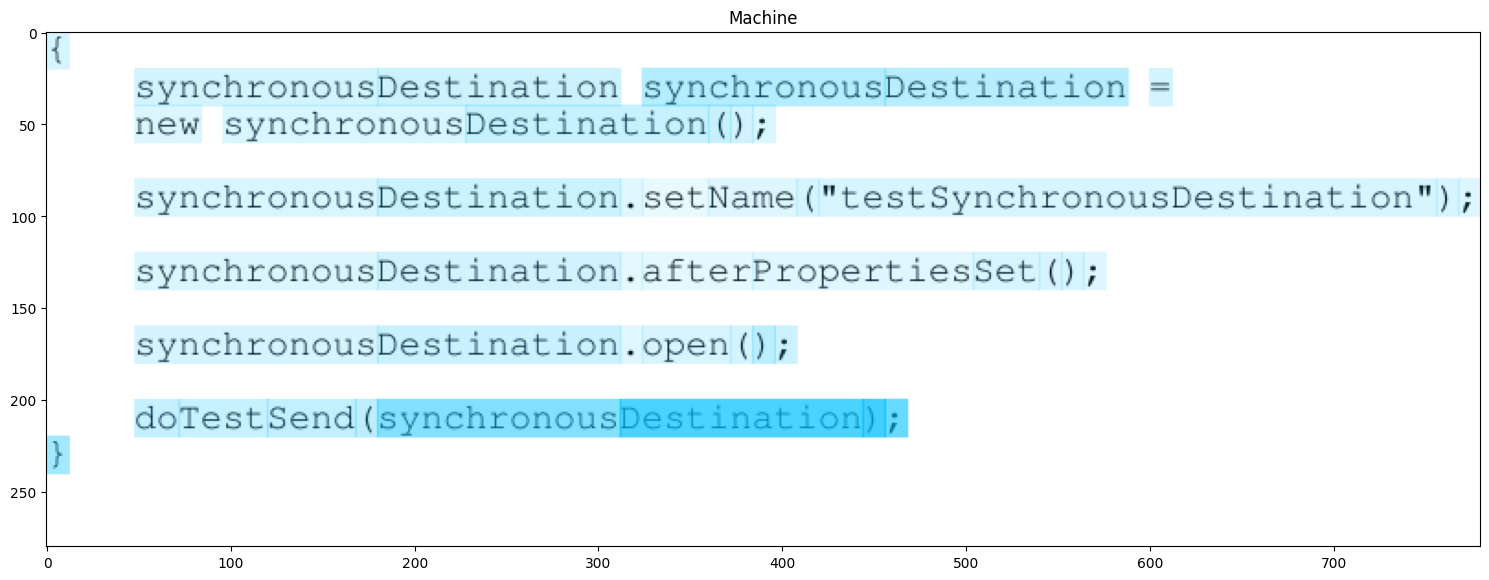

SURE > testsendtosynchronousdestination
COPY_AVG_spearman: -0.28636720125249476
AVG_spearman: -0.33292193815296495
<class 'PIL.Image.Image'>


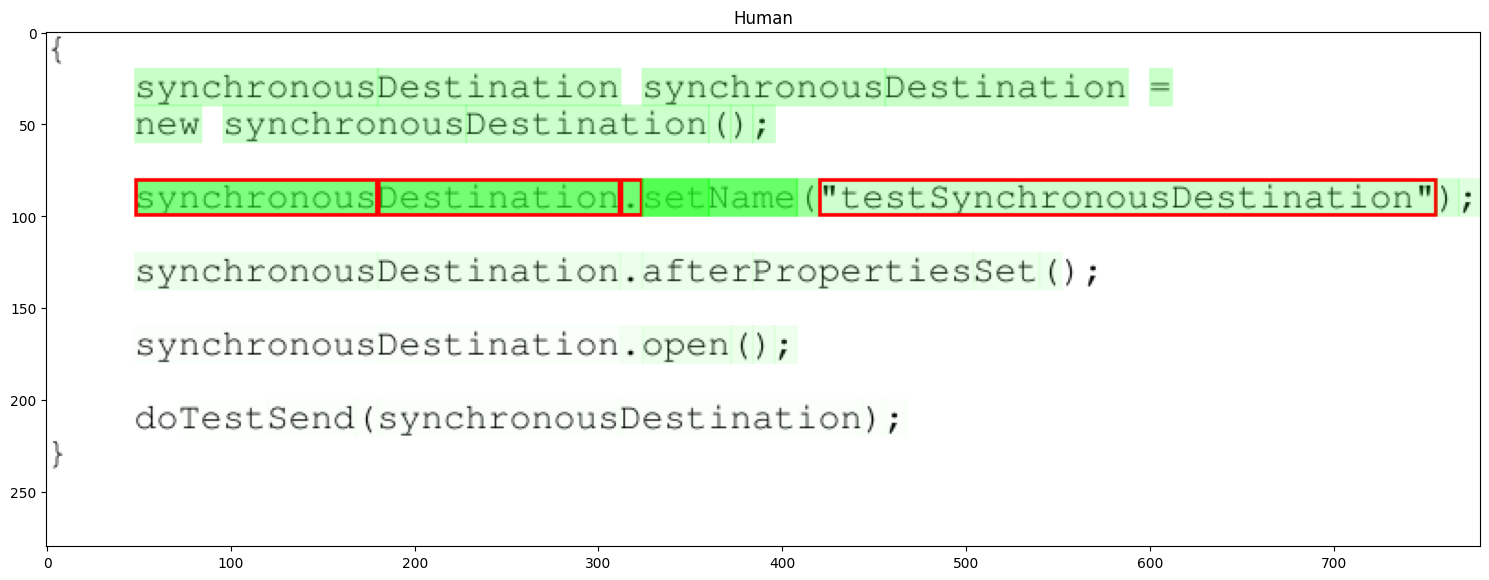

**************************************************  CODE:  ee9be781fc52e43c068b8f02ca2a45c8
NoobTech > testsendtosynchronousdestination
COPY_AVG_spearman: 0.6048476636642419
AVG_spearman: 0.44054520868294894
<class 'PIL.Image.Image'>


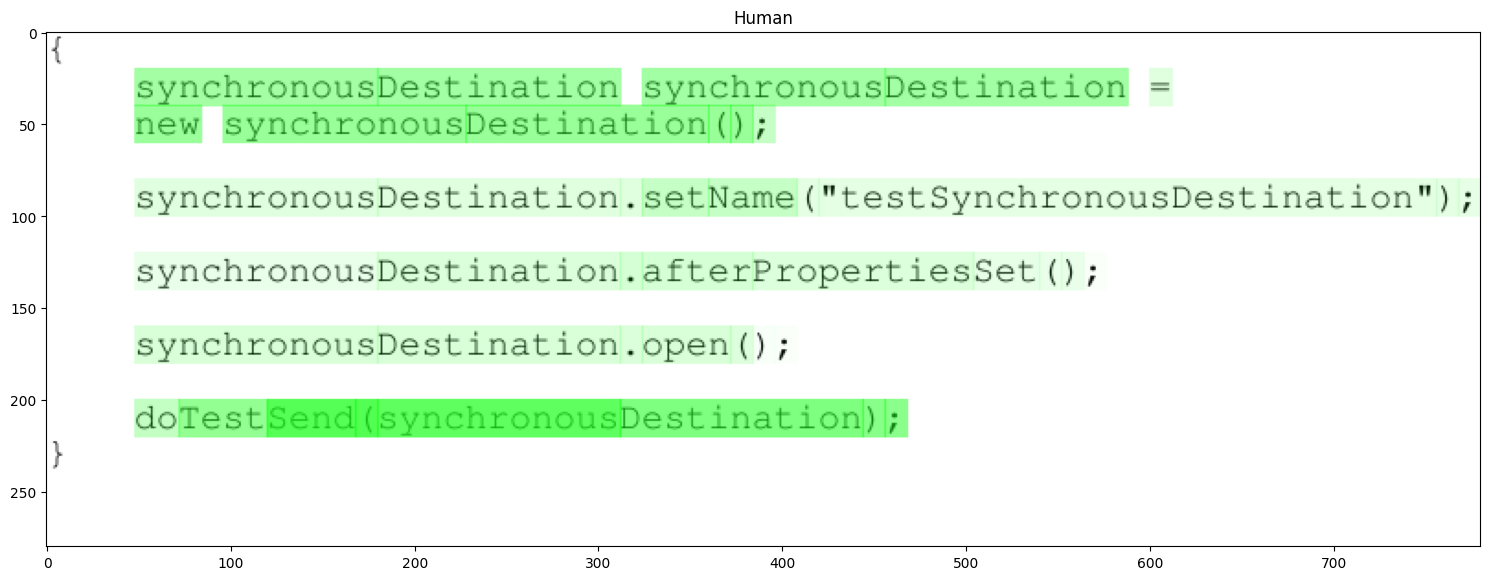

**************************************************  CODE:  ee9be781fc52e43c068b8f02ca2a45c8
doro > testsendtosynchronousdestination
COPY_AVG_spearman: -0.24256067111967294
AVG_spearman: -0.3736162078929516
<class 'PIL.Image.Image'>


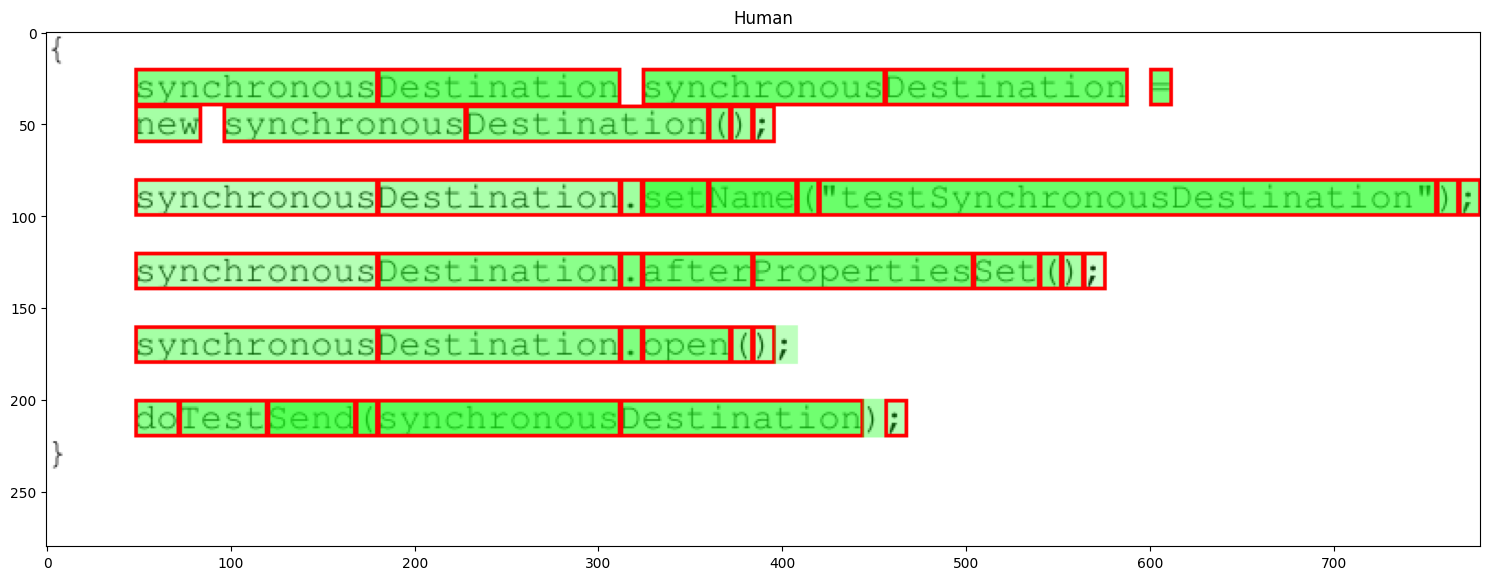

**************************************************  CODE:  ee9be781fc52e43c068b8f02ca2a45c8
A1MHQM806YCQV3 > testsendtosynchronousdestination
COPY_AVG_spearman: 0.6231943535817359
AVG_spearman: 0.3240261754452273
<class 'PIL.Image.Image'>


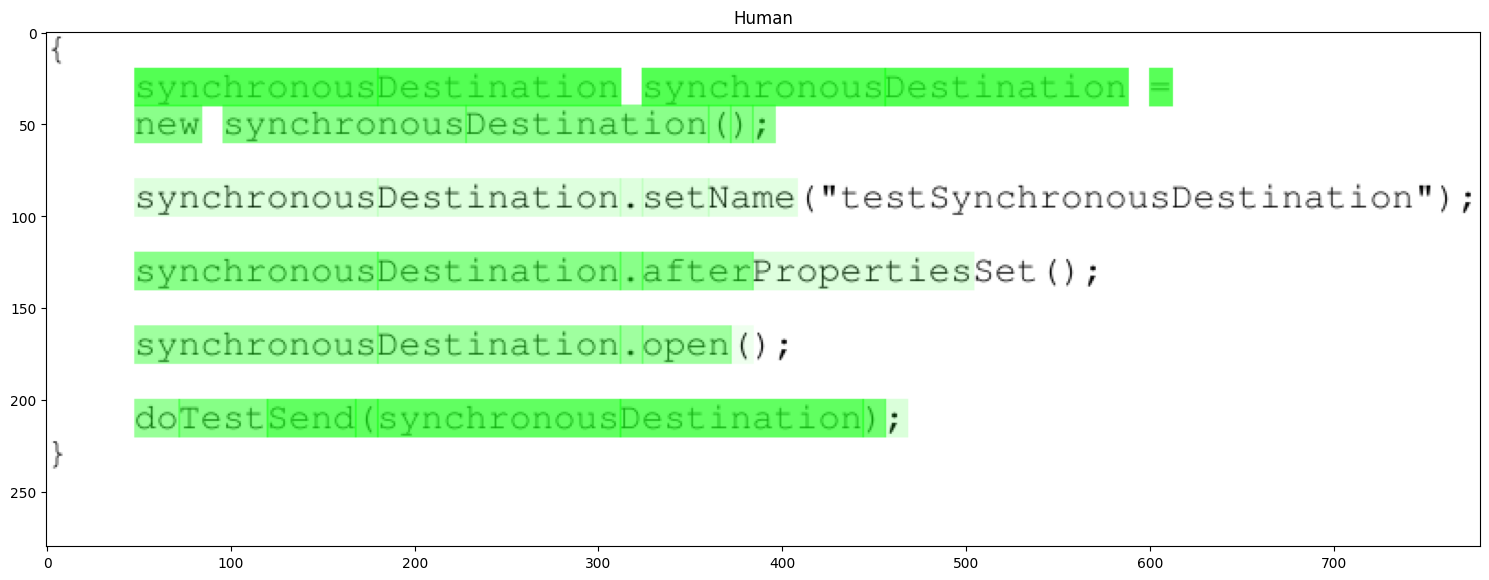

**************************************************  CODE:  ee9be781fc52e43c068b8f02ca2a45c8
3264610 > testsendtosynchronousdestination
COPY_AVG_spearman: 0.17252120482676297
AVG_spearman: 0.0037625289576090604
<class 'PIL.Image.Image'>


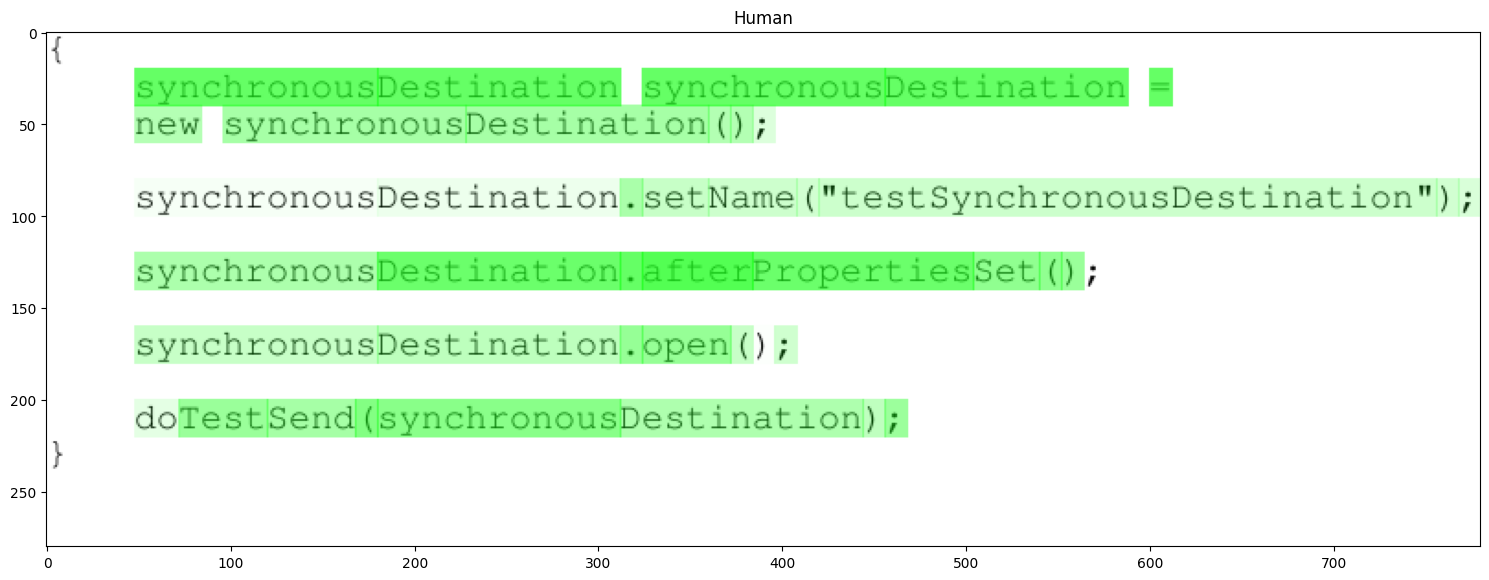

**************************************************  CODE:  ee9be781fc52e43c068b8f02ca2a45c8
Polimi-LucaMolteni > testsendtosynchronousdestination
COPY_AVG_spearman: 0.2403849175475312
AVG_spearman: 0.20195540673610907
<class 'PIL.Image.Image'>


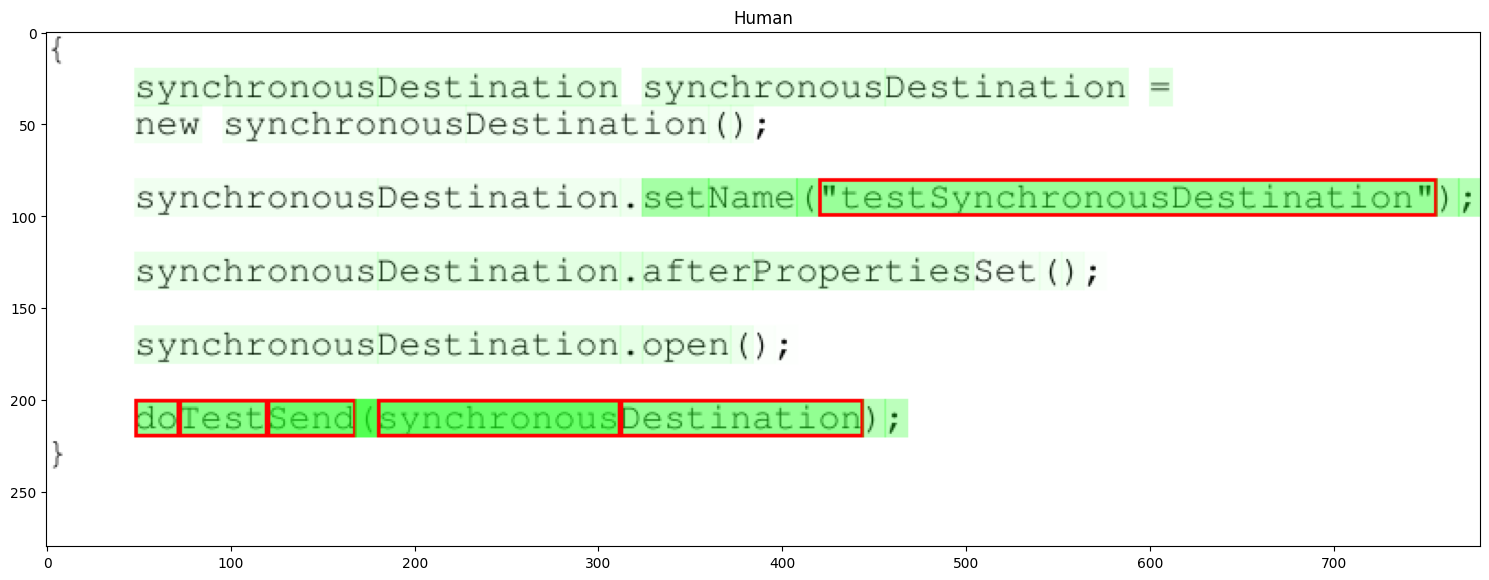

In [41]:
# change machine_col to see the copy attention
cmp_allamanis.plot_token_heatmap_side_by_side(
    machine_col='att_vector_avg', #'copy_att_vector_avg',
    limit=None, 
    only_functions=None,
    only_uuids=['ee9be781fc52e43c068b8f02ca2a45c8'], 
    only_users=None,
    columns_to_observe=['COPY_AVG_spearman', 'AVG_spearman'],
    save_first=6,
    out_folder='saved_token_maps'
)